In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from statsmodels.tsa.stattools import adfuller, acf, pacf
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.arima.model import ARIMA
from xgboost import XGBRegressor
from sklearn.model_selection import TimeSeriesSplit
from sklearn.model_selection import GridSearchCV
from sklearn.preprocessing import StandardScaler
import statsmodels.api as sm
from sklearn.metrics import mean_squared_error

In [2]:
lob_data= pd.read_csv("C:/Users/keert/OneDrive/Desktop/Mini Project/resampled_lob_secs2.csv")
lob_data['Datetime'] = pd.to_datetime(lob_data['Datetime'])

lob_data['price']=(lob_data['Max Bid Price']*lob_data['Max Bid Quantity']+lob_data['Min Ask Price']*lob_data['Min Ask Quantity'])/(lob_data['Max Bid Quantity']+lob_data['Min Ask Quantity'])
# lob_data

In [3]:
# ofi
def calculate_ofi(df):
    df['delta_bid'] = df['Max Bid Price'].diff().fillna(0)
    df['delta_ask'] = df['Min Ask Price'].diff().fillna(0)
    
        
    df['delta_w'] = df.apply(
        lambda row: row['Max Bid Quantity'] if row['delta_bid'] > 0 else
                   (-row['Max Bid Quantity'] if row['delta_bid'] < 0 else
                    row['Max Bid Quantity'] - df.loc[df.index[df.index.get_loc(row.name)-1], 'Max Bid Quantity']
                    if row.name > 0 else 0),
        axis=1)
    
    
    df['delta_v'] = df.apply(
        lambda row: -row['Min Ask Quantity'] if row['delta_ask'] > 0 else
                   (row['Min Ask Quantity'] if row['delta_ask'] < 0 else
                    row['Min Ask Quantity'] - df.loc[df.index[df.index.get_loc(row.name)-1], 'Min Ask Quantity']
                    if row.name > 0 else 0),
        axis=1)
    
    
    df['ofi'] = df['delta_w'] + df['delta_v']
    
    return df['ofi']

calculate_ofi(lob_data)
lob_data=lob_data[['Datetime','Min Ask Price','Max Bid Price','price','Total Bid Quantity','Total Ask Quantity','Min Ask Quantity','Max Bid Quantity','ofi']]
# drop the first row (ofi is 0)
lob_data = lob_data.iloc[1:]

In [4]:
def calculate_rsi(data, window):
    
    delta = data.diff()
    gain = (delta.where(delta > 0, 0)).rolling(window=window).mean()
    loss = (-delta.where(delta < 0, 0)).rolling(window=window).mean()

    rs = gain / loss
    rsi = 100 - (100 / (1 + rs))
    return rsi

lob_data['RSI'] = calculate_rsi(lob_data['price'], window=5) # calculate RSI
lob_data['MA'] = lob_data['price'].rolling(window=5).mean() # Cclculate moving avg
lob_data['Momentum'] = lob_data['price'] - lob_data['price'].shift(5) # Calculate momentum
# lob_data.head()

In [5]:
# This is only for trading volume, not for modeling

rolling_window = 5  
lob_data['Log Return Max Bid'] = np.log(lob_data['Max Bid Price'] / lob_data['Max Bid Price'].shift(1))
lob_data['Log Return Min Ask'] = np.log(lob_data['Min Ask Price'] / lob_data['Min Ask Price'].shift(1))


lob_data['Volatility Max Bid'] = lob_data['Log Return Max Bid'].rolling(window=rolling_window).std()
lob_data['Volatility Min Ask'] = lob_data['Log Return Min Ask'].rolling(window=rolling_window).std()


# Trading volume
def adjust_trade_quantity(volatility, max_tradeable_quantity, base_quantity=1, risk_tolerance=0.5, scaler_fator=10):
    
    adjusted_quantity = base_quantity / (volatility*risk_tolerance*scaler_fator)
    adjusted_quantity = max(1, round(adjusted_quantity))  
    final_trade_quantity = min(adjusted_quantity, max_tradeable_quantity)

    return final_trade_quantity

In [6]:
# split data
lob_data.columns

Index(['Datetime', 'Min Ask Price', 'Max Bid Price', 'price',
       'Total Bid Quantity', 'Total Ask Quantity', 'Min Ask Quantity',
       'Max Bid Quantity', 'ofi', 'RSI', 'MA', 'Momentum',
       'Log Return Max Bid', 'Log Return Min Ask', 'Volatility Max Bid',
       'Volatility Min Ask'],
      dtype='object')

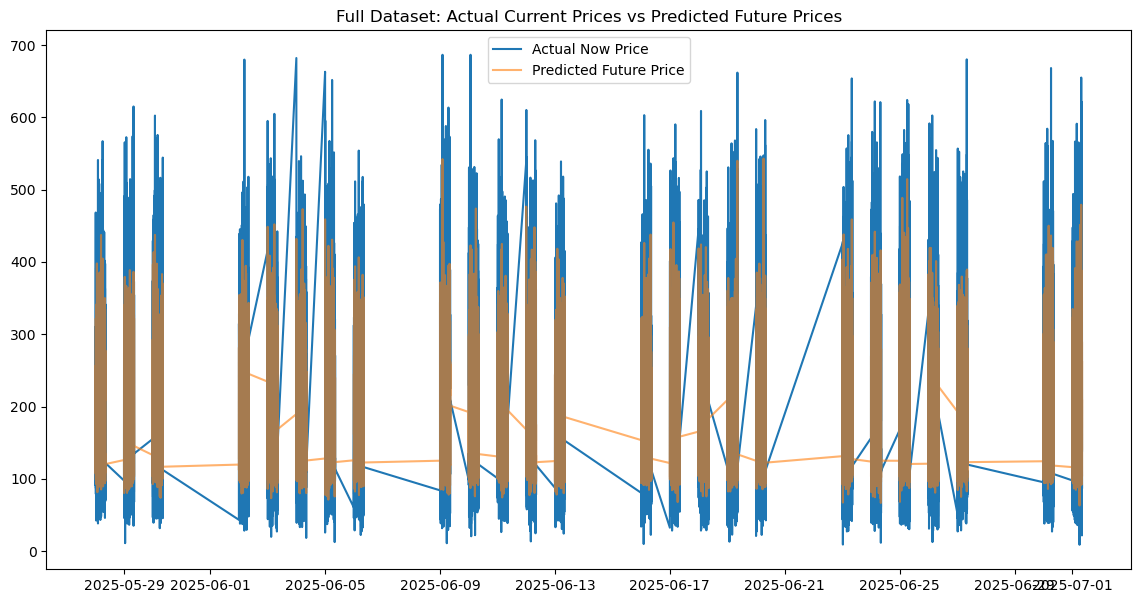

In [38]:
import pandas as pd
import numpy as np
from xgboost import XGBRegressor
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt


# Prepare the target column for future prices
lob_data['future_price'] = lob_data['price'].shift(-1)
lob_data.dropna(inplace=True)  # Drop the last row with NaN 'future_price'

# Split the data while respecting the time series nature (no random split)
split_index = int(0.8 * len(lob_data))
train_data = lob_data[:split_index]
test_data = lob_data[split_index:]

# Select features
features = [col for col in lob_data.columns if col not in ['Datetime', 'Min Ask Price', 'Max Bid Price', 'future_price']]
X_train = train_data[features]
y_train = train_data['future_price']
X_test = test_data[features]
y_test = test_data['price']

# Scale features
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Train the model
model = XGBRegressor(objective='reg:squarederror', n_estimators=100, random_state=42)
model.fit(X_train_scaled, y_train)

# Generate predictions
predictions = model.predict(X_test_scaled)

# Plotting the current vs predicted future price for the entire dataset
plt.figure(figsize=(14, 7))
plt.plot(test_data['Datetime'], y_test, label='Actual Now Price')
plt.plot(test_data['Datetime'], np.roll(predictions, 1), label='Predicted Future Price', alpha=0.6)  # Shift predictions to align with current price
plt.legend()
plt.title('Full Dataset: Actual Current Prices vs Predicted Future Prices')
plt.show()




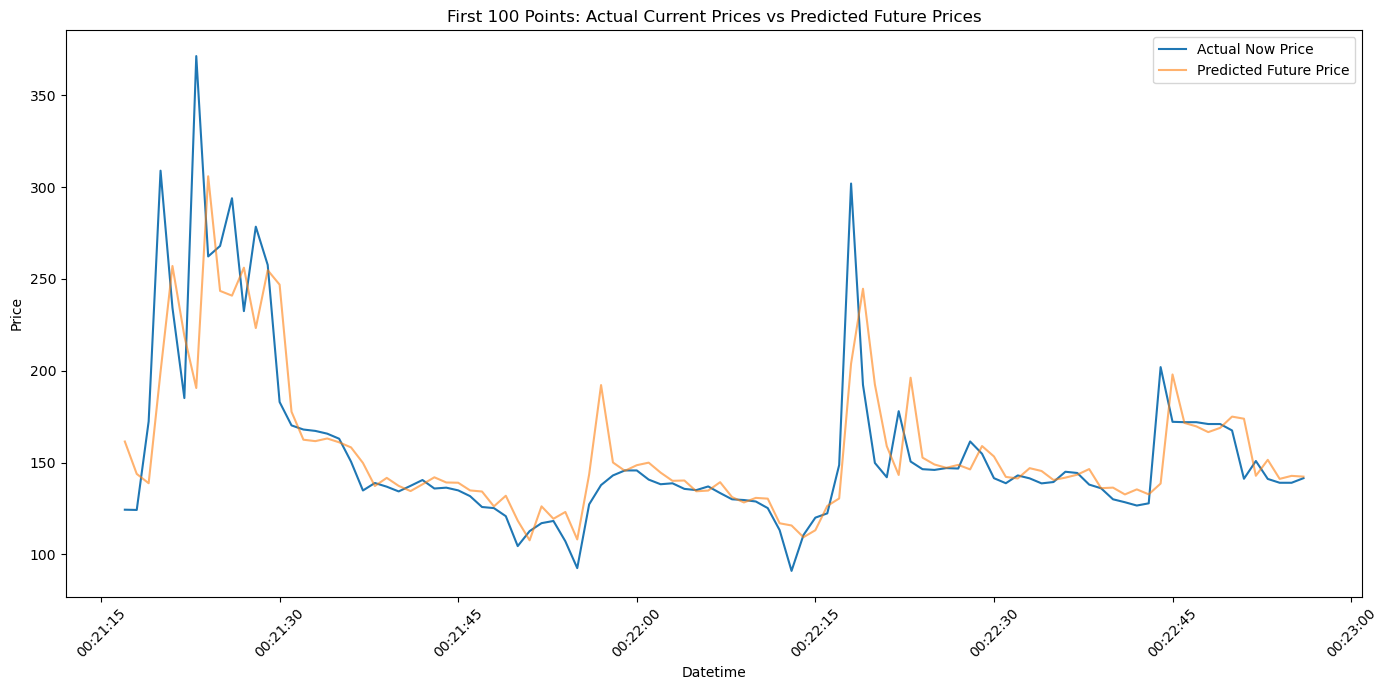

In [28]:
# plotting for the first 100 points
plt.figure(figsize=(14, 7))
plt.plot(test_data['Datetime'][:100], y_test[:100], label='Actual Now Price')
plt.plot(test_data['Datetime'][:100], np.roll(predictions, 1)[:100], label='Predicted Future Price', alpha=0.6)  # Shift predictions to align with current price
plt.legend()
plt.title('First 100 Points: Actual Current Prices vs Predicted Future Prices')
plt.xlabel('Datetime')
plt.ylabel('Price')
plt.xticks(rotation=45)  # Rotate the x-axis labels for better readability
plt.tight_layout()  # Adjust the layout to make room for the x-axis labels
plt.show()

In [29]:
# Evaluation Metrics
mae = mean_absolute_error(y_test, np.roll(predictions, 1))
mse = mean_squared_error(y_test, np.roll(predictions, 1))
rmse = np.sqrt(mse)
r2 = r2_score(y_test, np.roll(predictions, 1))

print(f"Mean Absolute Error (MAE): {mae:.4f}")
print(f"Mean Squared Error (MSE): {mse:.4f}")
print(f"Root Mean Squared Error (RMSE): {rmse:.4f}")
print(f"R-squared (R²): {r2:.4f}")

Mean Absolute Error (MAE): 19.2738
Mean Squared Error (MSE): 1005.5262
Root Mean Squared Error (RMSE): 31.7100
R-squared (R²): 0.4557


In [44]:
def trading_simulator(prices, signals, initial_capital=10000, transaction_cost_rate=0.0005, max_shares_per_trade=1000):
    capital = initial_capital
    position = 0
    capital_history = []
    total_trades = 0  # Track the total number of trades (both buys and sells)

    for price, signal in zip(prices, signals):
        if price <= 0:  # Prevent division by zero or negative prices
            continue

        if signal == 1 and capital >= price:  # Buy
            shares = int(min(capital / price, max_shares_per_trade))  # Limit the number of shares
            if shares > 0:
                capital -= shares * price
                position += shares
                total_trades += 1  # Increment trade count for each buy

        elif signal == -1 and position > 0:  # Sell
            capital += position * price
            position = 0
            total_trades += 1  # Increment trade count for each sell

        # Prevent capital from becoming excessively large
        capital = min(capital, 1e6)  # Cap the capital to prevent overflow

        capital_history.append(capital + position * price if position > 0 else capital)

    final_portfolio_value = capital + position * prices[-1] if position > 0 else capital
    profit = final_portfolio_value - initial_capital

    # Calculate normalized profit
    normalized_profit = profit / total_trades if total_trades > 0 else 0  # Avoid division by zero

    return profit, normalized_profit, capital_history

# print the profit
profit, normalized_profit, capital_history = trading_simulator(current_prices, signals, initial_capital=10000)
print(f"Final profit from trading simulation: ${profit:.2f}")
print(f"Normalized profit per trade: ${normalized_profit:.2f}")


Final profit from trading simulation: $888147.50
Normalized profit per trade: $2.14
